In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import pycaret
import sklearn
import matplotlib.pyplot as plt

# Load data
We start by loading only the transactions involved, to be able to select these for model training

In [3]:
trx = pd.read_csv('amlsim-data/10K/transactions.csv')
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197905 entries, 0 to 197904
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tran_id         197905 non-null  int64  
 1   orig_acct       197905 non-null  int64  
 2   bene_acct       197905 non-null  int64  
 3   tx_type         197905 non-null  object 
 4   base_amt        197905 non-null  float64
 5   tran_timestamp  197905 non-null  object 
 6   is_sar          197905 non-null  bool   
 7   alert_id        197905 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 10.8+ MB


In [9]:
trx.head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id
0,1,4376,170,TRANSFER,885.30,2017-01-01T00:00:00Z,False,-1
1,2,4300,23,TRANSFER,630.41,2017-01-01T00:00:00Z,False,-1
2,3,4433,12,TRANSFER,393.14,2017-01-01T00:00:00Z,False,-1
3,4,2552,6503,TRANSFER,659.74,2017-01-01T00:00:00Z,False,-1
4,5,2552,6503,TRANSFER,442.44,2017-01-01T00:00:00Z,False,-1


In [4]:
trx.describe()

,tran_id,orig_acct,bene_acct,base_amt,alert_id
count,197905.000000,197905.000000,197905.000000,197905.000000,197905.000000
mean,98953.000000,1909.848776,569.676481,546.631910,-0.823547
std,57130.396849,1618.013120,1695.983714,261.671165,3.472225
min,1.000000,0.000000,0.000000,0.090000,-1.000000
25%,49477.000000,461.000000,24.000000,319.580000,-1.000000
50%,98953.000000,2098.000000,53.000000,546.780000,-1.000000
75%,148429.000000,2738.000000,191.000000,772.290000,-1.000000
max,197905.000000,12007.000000,11991.000000,999.990000,99.000000


# Setup data and feature prep
PyCaret has a setup() function that prompts us with data setup out of the box. We run it here to create training/test data in the right format

In [5]:
from pycaret.classification import *

In [6]:
test = setup(data=trx, target='is_sar')

,Description,Value
0,session_id,3632
1,Target,is_sar
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(197905, 8)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


# Train various models and compare performance
The `compare_models()` function lets us train and compare various models. Here we select the best 5

In [7]:
top5 = compare_models(n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,0.9996,0.9897,1.0000,0.9948,0.9947,0.9948,2.1580
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0680
rf,Random Forest Classifier,1.0000,1.0000,0.9979,1.0000,0.9989,0.9989,0.9989,1.9470
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0770
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,6.0610
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4950
et,Extra Trees Classifier,0.9999,1.0000,0.9731,1.0000,0.9863,0.9863,0.9864,3.5330
lda,Linear Discriminant Analysis,0.9991,0.9050,0.7543,1.0000,0.8592,0.8588,0.8677,0.3230
svm,SVM - Linear Kernel,0.9990,0.0000,0.7087,1.0000,0.8235,0.8231,0.8382,0.3740
ridge,Ridge Classifier,0.9989,0.0000,0.6799,1.0000,0.8087,0.8082,0.8237,0.0680


# Evaluate model scores
Evaluate the model using graphs to interpret the results

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

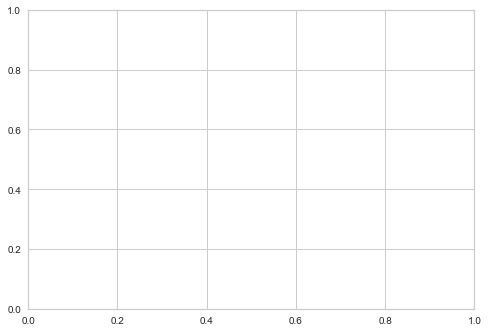

In [8]:
evaluate_model(top5[0])